#**Section 1: Install Dependencies**

In [16]:
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#**Section 2: Importing Relevant Modules**

In [17]:
import openai
import uuid
import pandas as pd
import nltk
import warnings
import seaborn as sns
import numpy as np
warnings.filterwarnings("ignore")
import openai
import uuid
import pandas as pd
import numpy as np
import time

### **TODO 1:** Go to https://beta.openai.com/playground and there must be a personal icon on the top right hand side, click on that and go to "View API Keys". It will open a new view and you can see the "Secret Key" there, copy the same and paste it within the quotes below. 

In [18]:
openai.api_key= "" ################ TODO : Enter Your Api Key Here"#############

#**Section 3: Important Classes for the Code**

### **Example Class:** The example class takes input, output, id. We are using this class later to train the gpt3 (few shot learning) with an input and output

In [19]:
class Example:

   # Stores an input, output pair and formats it to prime the model
   def __init__(self, input, output):
       self.input = input
       self.output = output
       self.id = uuid.uuid4().hex

   # To obtain the input provided for an example
   def get_input(self):
       return self.input

   # To obtain the output provided for an example
   def get_output(self):
       return self.output

   # To obtain the unique id of an example
   def get_id(self):
       return self.id

### **GPT3 Class:** 
</br>

**Important things to note:**
*   The gpt3 class will take inputs of **engines, temperature, max_tokens,** description and other important parameters to be sent to gpt3
*   The submit_request method will send the request to openai and receive a response in return. 
</br>

*This class is very important for this practical. Its important to understand this well*

In [5]:
class GPT3:

   # initialises parameters and adds default values
   def __init__(self, describe_task = "", engine='davinci', temperature=0.5, max_tokens=100,

       input_prefix="input: ", input_suffix="\n", output_prefix="output: ",
       output_suffix="\n\n", append_output_prefix_to_query=False):
       self.examples = {}
       self.engine = engine
       self.temperature = temperature
       self.max_tokens = max_tokens
       self.input_prefix = input_prefix
       self.input_suffix = input_suffix
       self.output_prefix = output_prefix
       self.output_suffix = output_suffix
       self.append_output_prefix_to_query = append_output_prefix_to_query
       self.stop = (output_suffix + input_prefix).strip()
       self.description = describe_task

   # Adds an example to the model object. Example is an instance of the Example class.
   def add_example(self, ex):
       self.examples[ex.get_id()] = ex

   # Converts all the examples to a particular format to prime the model.
   def get_prime_text(self):
       return "".join(
           [self.format_example(ex) for ex in self.examples.values()])

   # Creates a query for the API request
   def craft_query(self, prompt):
       #print("description in cratft query",self.description)
       q = self.description+self.get_prime_text(
       ) + self.input_prefix + prompt + self.input_suffix

       #print(q)
       if self.append_output_prefix_to_query:
           q = q + self.output_prefix
       return q

   # Calls the API using the Completion endpoint with the specified values of the parameters
   def submit_request(self, prompt):
       response = openai.Completion.create(engine=self.engine,
                                           prompt=self.craft_query(prompt),
                                           max_tokens=self.max_tokens,
                                           temperature=self.temperature,
                                           top_p=1,
                                           n=1,
                                           stream=False,
                                           stop=self.stop)
       return response

   # Formats the input output pair with appropriate prefixes and suffixes
   def format_example(self, ex):
       return self.input_prefix + ex.get_input(
       ) + self.input_suffix + self.output_prefix + ex.get_output(
       ) + self.output_suffix

## **To Do:** Download 'twitter_classification.csv' file from the github and upload to colab

# **Task 1: Study Impact of Different *GPT3* Parameters on Accuracy of Twitter Classification**

#### **Load the Twitter data**

In [21]:
sentiment_df= pd.read_csv('twitter_classification.csv')

sentiment_df

,label,text
0,Positive,@FionaFlame With Florence - but not OH
1,Positive,@mileycyrus Watch britains got talent final i...
2,Negative,@Pippa14 Oh man i wish!!!! i would loooooove t...
3,Negative,Damn! The Firefox poker aint loading!
4,Negative,"Aww, the free Sugar Ray show tonight was cance..."
...,...,...
195,Negative,@RowdyKittens So bummed I'm going to be missin...
196,Positive,"Yumm eating my chicken, rice, potatoes and squ..."
197,Positive,@captainjack63 Thanks for following
198,Negative,I have a toothache and am tweeting in sick


#### **Checking if Dataset is balanced**

In [22]:
sentiment_df['label'].value_counts()

Positive    100
Negative    100
Name: label, dtype: int64

#### **Creating a GPT3 Object**
This was created using GPT3 class from section 3

In [23]:
gpt3_tweet = GPT3(engine="davinci", temperature=0.3, max_tokens=60)

#### **Creating a training dataset for gpt3**

In [24]:
## Create a train dataframe to add the example and label for few shot learning 

no_of_shots = 10
train_df=sentiment_df[['label','text']].sample(n=no_of_shots) 

#### **Creating a test dataset for gpt3**


In [25]:
## Test Data to Classify Tweet Sentiment and Calculate Accuracy

no_of_samples = 30 
test_df=sentiment_df[['label','text']].sample(n=no_of_samples) 

#### **Creating a function for training gpt3**

Notice the use of add_example(), add_example() was in section 3 </br>
**TODO 2:** 

#### Please include your answer here: This is train function definition, where text and labels are passed to the gpt3 tweet class for training

In [26]:
## Defining Training function for GPT3

def train_gpt3(train_df):
  for i in range(len(train_df)):
    example = [train_df.iloc[i]['text'], train_df.iloc[i]['label']]
    gpt3_tweet.add_example(Example(example[0],example[1]))

#### **Creating a function for testing gpt3 and returning accuracy**
Notice the use of submit_request(), reference section 2. </br>
**TODO 3:** Please comment on what is submit_request() doing


#### Please include your answer here: For every test case submitting the request to the GPT3 api for prediction.

In [31]:
## Defining Test functions for Calculating Accuracy for Different Parameters 
def test_gpt3(test_df):
  PREDICTED_OUTPUT=[]
  IS_ACTUAL_PREDICTED=[]
  for i in range(len(test_df)):
    prompt=test_df.iloc[i]['text']
    output=gpt3_tweet.submit_request(prompt)
    PREDICTED_OUTPUT.append((output.choices[0].text).split()[1])
  
  ## Store Predictions to the test dataframe 
  test_df['Predicted Sentiment']=PREDICTED_OUTPUT

  ## Check if Predicted Sentiment is same as Actual Sentiment
  for i in range(len(test_df)):
    IS_ACTUAL_PREDICTED.append(test_df.iloc[i]['label']==test_df.iloc[i]['Predicted Sentiment'])

  test_df['Actual vs Predicted']=IS_ACTUAL_PREDICTED

  ## Accuracy Score
  filt = (test_df['Actual vs Predicted']==True)
  a=test_df[filt]['Actual vs Predicted'].value_counts()/len(test_df)

  ## b is the accuracy
  accuracy=a.iloc[0]

  return accuracy 

## **Plot the Accuracy Scores for Different Engines**

**TODO 4:**
1. Enter value for temperature and max_tokens. Temperature is between 0 and 1 and max_tokens can be upto 2048 </br>
2. Try removing the timer and test the code. Does it run smoothly? What is the significance of timer? You can try these 2 values 10 and 60 for timer. What were your observations? 
3. What is the difference between different engines, why are their accuracies different?
4. Which engine gives the highest accuracy and why?

**Please Note:** This code takes a while to execute due to timer. While your code is running, please work on the code of following tasks



#### Please include your answer here: 

1. Timer with anything other than 60 doesn't run. Timer is rate calls per minute, so on safer side, program can run 60 requests per minute
2. text da vinci gives the highest accuracy.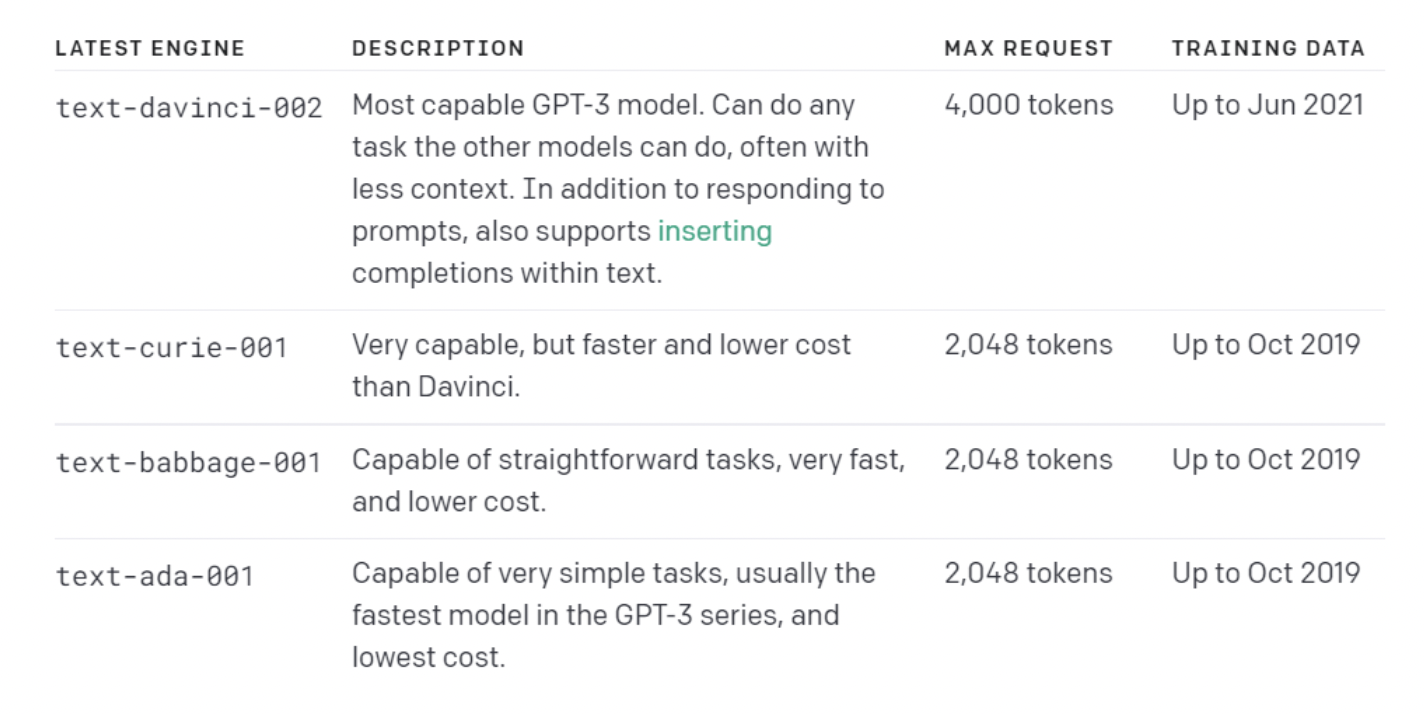

In [28]:
## Engine Variation
engines=['text-davinci-002','text-curie-001','text-babbage-001','text-ada-001','curie','babbage','ada']

temperature = 0.4 ######### TODO : PROVIDE TEMPARATURES VALUE #########

max_tokens = 100 ######### TODO : PROVIDE MAX_TOKENS VALUE #########

accuracy=[]

for index in range(len(engines)):

  print("Engine running: ", engines[index])

  gpt3_tweet = GPT3(engine=engines[index], temperature=temperature, max_tokens=max_tokens) 
  
  ## train the model
  train_gpt3(train_df)

  ## test the model 
  output=test_gpt3(test_df)

  ## store accuracy 
  accuracy.append(output)

  ## sleep to prevent rate limit error 
  time.sleep(60) ######### TODO : UPDATE SLEEP TIME and CHECK THE RESPONSE IF NECESSARY#########

Engine running:  text-davinci-002
Engine running:  text-curie-001
Engine running:  text-babbage-001
Engine running:  text-ada-001
Engine running:  curie
Engine running:  babbage
Engine running:  ada


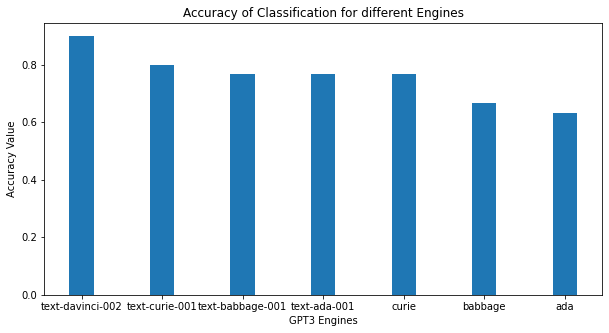

In [29]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(engines, accuracy, width = 0.3)
 
plt.xlabel("GPT3 Engines")
plt.ylabel("Accuracy Value")
plt.title("Accuracy of Classification for different Engines")
plt.show()

## **Plot the Accuracy Scores for Different Temperatures**

**TODO 5:**

1. Calculate Accuracy Scores for different Temperature Setting while keeping engines and max_tokens constant 

2. Plot graph of accuracy with temperature 

3. Please comment on how accuracy of classification changes with change in temperature

**Hint**: You can refer to code from previous part for this section

**Please Note:** This code takes a while to execute due to timer. While your code is running, please work on the code of following tasks


*Please consider atleast 5 different temperature setting*

#### Please include your observations here: 

Observation : As temperature controls the randomness, doesn't have much of an effect on the accuracy

In [32]:
## Write code for Subpart 1 here and store values of accuracy for different temperature setting
## Temperature Variation
engines='text-ada-001'

temperature = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0] ######### TODO : PROVIDE TEMPARATURES VALUE #########

max_tokens = 100 ######### TODO : PROVIDE MAX_TOKENS VALUE #########

accuracy=[]

for index in range(len(temperature)):

  print("Temperature running: ", temperature[index])

  gpt3_tweet = GPT3(engine=engines, temperature=temperature[index], max_tokens=max_tokens) 
  
  ## train the model
  train_gpt3(train_df)

  ## test the model 
  output=test_gpt3(test_df)

  ## store accuracy 
  accuracy.append(output)

  ## sleep to prevent rate limit error 
  time.sleep(60) ######### TODO : UPDATE SLEEP TIME and CHECK THE RESPONSE IF NECESSARY#########

Temperature running:  0.0
Temperature running:  0.2
Temperature running:  0.4
Temperature running:  0.6
Temperature running:  0.8
Temperature running:  1.0


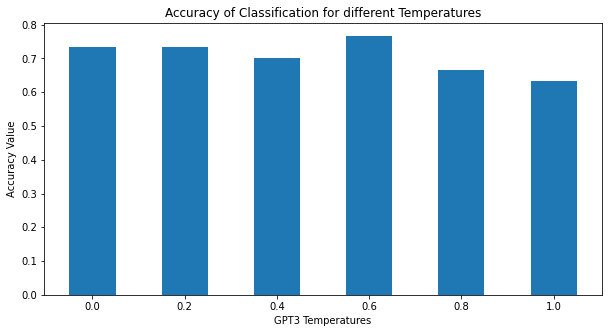

In [33]:
## Write code for Subpart 2 here and plot the graphs
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(temperature, accuracy, width = 0.1)
 
plt.xlabel("GPT3 Temperatures")
plt.ylabel("Accuracy Value")
plt.title("Accuracy of Classification for different Temperatures")
plt.show()

## **Plot the Accuracy Scores for Different Tokens**

**TODO 6:**

1. Calculate Accuracy Scores for different max_tokens setting while keeping engines and temperature constant. 

2. Plot graph of accuracy with max_token size 

3. Please comment on how accuracy of classification changes with change in max_tokens

**Please Note:** 
* We recommend that max_tokens value be less than 1700, as some tokens are used by the formating of prompt. 

* This code takes a while to execute due to timer. While your code is running, please work on the code of following tasks


**Hint**: You can refer to code from previous part for this section

*Please consider atleast 5 different max_tokens setting*

#### Please include your observations here: NO pattern with the number of tokens either as in case of temperatures

In [34]:
## Write code for Subpart 1 here and store values of accuracy for different max_token setting
## Tokens Variation
engines='text-ada-001'

temperature = 0.4 ######### TODO : PROVIDE TEMPARATURES VALUE #########

max_tokens = [100, 250, 1000, 1500, 1600] ######### TODO : PROVIDE MAX_TOKENS VALUE #########

accuracy=[]

for index in range(len(max_tokens)):

  print("Tokens running: ", max_tokens[index])

  gpt3_tweet = GPT3(engine=engines, temperature=temperature, max_tokens=max_tokens[index]) 
  
  ## train the model
  train_gpt3(train_df)

  ## test the model 
  output=test_gpt3(test_df)

  ## store accuracy 
  accuracy.append(output)

  ## sleep to prevent rate limit error 
  time.sleep(60) ######### TODO : UPDATE SLEEP TIME and CHECK THE RESPONSE IF NECESSARY#########

Tokens running:  100
Tokens running:  250
Tokens running:  1000
Tokens running:  1500
Tokens running:  1600


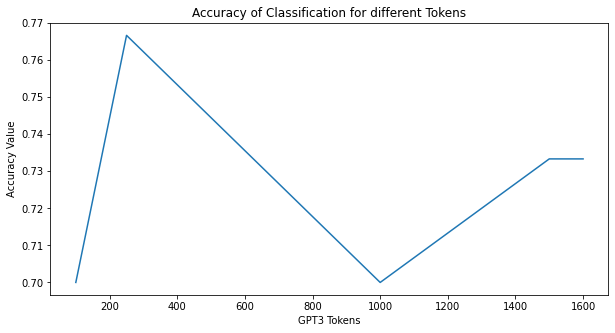

In [48]:
## Write code for Subpart 2 here and plot the graphs
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.plot(max_tokens, accuracy)
 
plt.xlabel("GPT3 Tokens")
plt.ylabel("Accuracy Value")
plt.title("Accuracy of Classification for different Tokens")
plt.show()

### **Optional:** Plot the Accuracy Scores for Different Training Size

Please complete task 2 before attempting this

# **Task 2: Generate Title from Abstract of the Research Paper**

## **Todo 7:** Create object of GPT3 class
 
Important parameters for your gpt3 object:
*   Choose an engine of your choice 
*   Choose a value for your temperature
*   describe_task => Give a one liner description of what you want the model to do or leave it blank. 
*   Recommended number for max_tokens is 150 for this task 





In [6]:
gpt3 = GPT3(engine="davinci", temperature=0.4, max_tokens=150)########## INSERT YOUR CODE HERE ##########

## **Todo 8:** Import data for this task

**File name:** 'Title_Abstract.csv'. </br>
**Task:** Upload csv to colab file and read the file below. 

In [8]:
data = pd.read_csv('Title_Abstract.csv') ########## INSERT YOUR CODE HERE ##########

##**Zero/Few Shot Learnings and Evaluation for Research Paper Title Creation**

In this task, we are experimenting with different number of shots and how accuracy changes with change in tokens 

**TODO 9**:

1. Enter the value of n, where n is index of one of the research papers you want to test on. 
2. Enter the max_number of shots. 
    * Question to consider: What is the maximum number of shots we can give for this task? 10? 20? 100? Experiment with code and share the answers with class. 
    * Based on your answer from previous question, what is the reason of upper limit on the number of shots. 
3. Use add_example() to train gpt3 with few shot learning
4. Send prompt to gpt3 and receive response 
5. Calculate BLEU Score and compare the reference and candidate. Reference: https://www.nltk.org/api/nltk.translate.bleu_score.html 


Hint for 3 and 4 subpart: train_gpt3() and test_gpt3() from Task 1 and Section 3

#### Please include your observations here: The maximum number of tokens can be upto 15. This is because our input is the abstract of a research paper which will take many tokens. This shows us the limitation of GPT-3.

In [12]:
n = 20 ########## INSERT YOUR CODE HERE ##########
prompt = data['abstract'][n]
actual_title = data['title'][n]

In [13]:
# TODO: Insert maximum number of shots 
max_number_of_shots = 10 ########## INSERT YOUR CODE HERE ##########
bleu_scores = []
shots=[number_of_shots for number_of_shots in range(max_number_of_shots)]

for number_shots in shots:
  for index_in_csv in range(number_shots):
      # TODO:
      # Create example object by using the abstract and title from the csv and add that example to the gpt3 object
      ########## INSERT YOUR CODE HERE ##########

      example = [data.iloc[index_in_csv]['abstract'], data.iloc[index_in_csv]['title']]
      gpt3.add_example(Example(example[0],example[1]))

  
  # TODO:
  # Submit the prompt using the suitable function from the GPT3 class
  response = gpt3.submit_request(prompt) ########## INSERT YOUR CODE HERE ##########

  response_list = response.choices[0].text.lower().split(" ")

  print("Number of shots: ", number_shots)
  print(response.choices[0].text) 

  # BLEU Score Calculations
  references = [actual_title.split()]
  candidate = response_list[1:]

  # TODO:
  # Calculate the BLEU Score using the references and canditate
  bl_score = nltk.translate.bleu_score.sentence_bleu(references, candidate)
  print("Score",bl_score)
  bleu_scores.append(bl_score)
  
  ########## INSERT YOUR CODE HERE ##########

  print("-------------------------------------------------")
  print("-------------------------------------------------")

  gpt3.examples={}

Number of shots:  0

This is joint work with J. M. A. Janssens, C. K. Wong, and J. B. Tenenbaum.
Score 9.257324954728539e-232
-------------------------------------------------
-------------------------------------------------
Number of shots:  1
output: The Matrix Tree Theorem and the Determinantal Process on Vector Bundles


Score 6.061838450024688e-155
-------------------------------------------------
-------------------------------------------------
Number of shots:  2
output: Cycle-rooted spanning forests and the matrix-tree theorem


Score 5.021333847570327e-78
-------------------------------------------------
-------------------------------------------------
Number of shots:  3
output: The determinant of the combinatorial Laplacian on a surface


Score 1.0518351895246305e-231
-------------------------------------------------
-------------------------------------------------
Number of shots:  4
output: Determinants of the Laplacian on graphs and vector bundles


Score 1.3842929588

## **Plot BLEU Scores with Number of Shots**

**TODO 10:**
1. Enter X and Y in the code. X represents data for x-axis and Y represents data for y-axis. 
2. Share your learning

#### Please include your observations here: This graph shows us that some shots are required to get a good BLEU score. 0-shot won't actually be the best BLEU score. This is because the GPT-3 model needs some shots to understand what it has to do. But the number of shots with good BLEU score can be different for each run.

[Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9')]

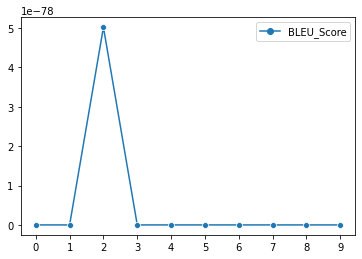

In [14]:
# TODO: Plot the graph using bleu_scores vs shots by replacing X,Y with the correct variables in below code
X = shots ########## INSERT YOUR CODE HERE ##########
Y = bleu_scores ########## INSERT YOUR CODE HERE ##########
score_per_shot = pd.DataFrame({'Number_of_Shots' : X, 'BLEU_Score' : Y})
score_per_shot.sort_values(by='BLEU_Score', ascending=False)
ax = sns.lineplot(data=[score_per_shot['BLEU_Score']], dashes=False, markers=True)
ax.set_xticks(range(len(score_per_shot['Number_of_Shots'])))
ax.set_xticklabels(score_per_shot['Number_of_Shots'])